# SurgeryHands Detection Model Training Parameter Analysis

We trained a detection model with a train / val / test datasets with video overlap before. This is problematic. 

Here are results and some accompanying commentary using a different train / val / test dataset without video overlap. Questions we want to answer:  
* Training on a more appropriately-shuffled dataset (videos in the test dataset are not seen in the training and validation sets), what is the evaluation performance?  
* If the performance is subpar, is it because of the dataset? Do we need more data?  
  * What else can be done to help generalize to never-before-seen videos?

***Quick Note***

I did this analysis quickly with experiment data that I copied to my local machine. The data itself might not be accessible or in a different directory / organizational structure than what's on the SAIL cluster or the GitHub repo. Apologies for any inconvenience!

(e.g. `scp mzhang@sc.stanford.edu:/pasteur/u/mzhang/surgery_hands/pytorch-retinanet/logs/* my_local_machine/surgeryhands/logs`)

In [14]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

In [15]:
import os

## Initial hyperparameter tuning

Considering learning rate and batch size, we compare results training a RetinaNet model (ResNet50-FPN backbone, pre-trained on ImageNet) on the newly split surgery dataset and the Oxford hands dataset as a baseline, evaluating on the newly split surgery test set.

### Load and sanity-check data

In [57]:
# Load dataframes for each training + validation run
dfs = []
for fname in os.listdir(path='../logs'):
    if '.csv' in fname:
        components = fname.split('-')
        dataset = components[1]
        try:
            dfs.append({
                'df': pd.read_csv('../logs/{}'.format(fname)),
                'dataset': dataset if dataset in ['oxford', 'surgery', 'oxford_train_val', 'surgery_train_val'] else '',
                'lr': fname.split('lr=')[1].split('-bs')[0],
                'bs': fname.split('bs=')[1].split('-npt')[0],
                'fname': fname
            })
        except:
            pass

In [58]:
for df in dfs:
    print(df['fname'])

training_log-lr=0.0001-bs=16-npt=False.csv
training_log-oxford-lr=0.0001-bs=16-npt=False.csv
training_log-oxford_train_val-lr=1e-05-bs=2-npt=False.csv
training_log-oxford_train_val-lr=1e-05-bs=4-npt=False.csv
training_log-oxford_train_val-lr=1e-05-bs=8-npt=False.csv
training_log-surgery-lr=0.0001-bs=16-npt=False.csv
training_log-surgery-lr=0.0001-bs=2-npt=False.csv
training_log-surgery-lr=0.0001-bs=4-npt=False.csv
training_log-surgery-lr=0.0001-bs=8-npt=False.csv
training_log-surgery-lr=1e-05-bs=16-npt=False.csv
training_log-surgery-lr=1e-05-bs=2-npt=False.csv
training_log-surgery-lr=1e-05-bs=4-npt=False.csv
training_log-surgery-lr=1e-05-bs=8-npt=False.csv
training_log-surgery-lr=1e-06-bs=16-npt=False.csv
training_log-surgery-lr=1e-06-bs=2-npt=False.csv
training_log-surgery-lr=1e-06-bs=4-npt=False.csv
training_log-surgery-lr=1e-06-bs=8-npt=False.csv
training_log-surgery_train_val-lr=1e-05-bs=2-npt=False.csv
training_log-surgery_train_val-lr=1e-05-bs=4-npt=False.csv
training_log-surgery

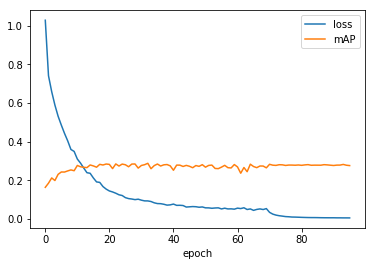

In [59]:
# Loss over 100 epochs looks reasonable!
dfs[0]['df'].plot('epoch')

### Surgery dataset training performance 

Training over 100 epochs, reporting mAP (mean average precision).

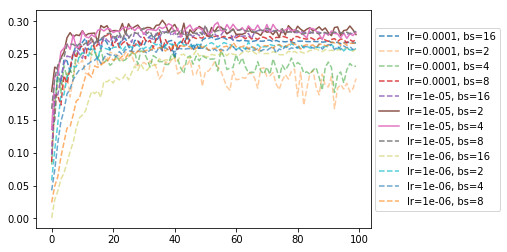

In [60]:
for df in dfs:
#     print(df['df']['mAP'].mean())
    if df['dataset'] == 'surgery':
        ls = '-' if df['df']['mAP'].mean() > 0.28 else '--'
        alpha = 1 - max([0, (0.28 - df['df']['mAP'].mean()) * 10])
        plt.plot(df['df']['epoch'], 
                 df['df']['mAP'],
                 label='lr={}, bs={}'.format(df['lr'], df['bs']),
                 ls=ls,
                 alpha=alpha)
plt.legend(loc='right', bbox_to_anchor=(1.4, 0.5))

### Isolate the good performers 

Let's go with:
* Learning rate: 1e-5
* Batch size: 4 or 8

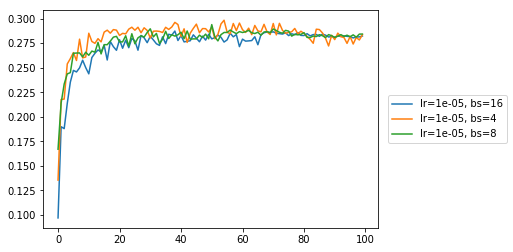

In [61]:
for df in dfs:
#     print(df['df']['mAP'].mean())
#     ls = '-' if df['df']['mAP'].mean() > 0.28 else '--'
    if df['df']['mAP'].iloc[-1] > 0.28:
        plt.plot(df['df']['epoch'], 
                 df['df']['mAP'],
                 label='lr={}, bs={}'.format(df['lr'], df['bs']),
                 ls='-')
plt.legend(loc='right', bbox_to_anchor=(1.4, 0.5))

## Full dataset (train + val splits) evaluation

Evaluation over time, reporting mAP from training model on full dataset (Surgery vs Oxford) on the Surgery test split.

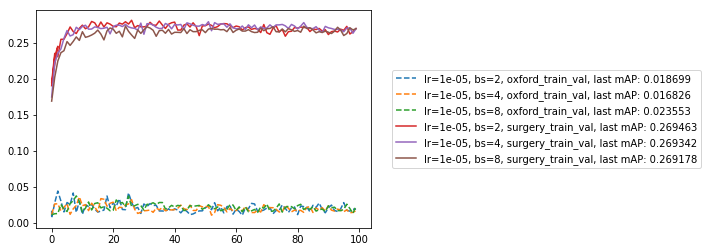

In [62]:
for df in dfs:
#     print(df['df']['mAP'].mean())
    if 'train_val' in df['fname']:
        # ls = '-' if df['df']['mAP'].mean() > 0.28 else '-'
        ls = '-' if 'surgery' in df['dataset'] else '--'
        
        if df['lr'] == '1e-05':
            plt.plot(df['df']['epoch'], 
                     df['df']['mAP'],
                     label='lr={}, bs={}, {}, last mAP: {:3f}'.format(df['lr'], df['bs'], df['dataset'], df['df']['mAP'].iloc[-1]),
                     ls=ls)
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))

## Findings

Training on surgery performs a lot better than on Oxford, but this number is still a lot less than that previously reported with the old dataset (mAP = 62.65%)

Optimal hyperparameter changes as well: lr=1e-5 (vs lr=1e-4 before).

## Checking performance on the old dataset

The above results are pretty bad compared to what was previously reported. To better isolate if this is a result of the dataset being inadequate, we can sanity-check the current repo and see if we can reproduce previous results with the previous dataset.

Namely, the previous codebase was mostly Keras + Tensorflow. I setup my own experiments and code at `/pasteur/u/mzhang/surgery_hands/` which runs with a popular Pytorch-based RetinaNet implementation (https://github.com/yhenon/pytorch-retinanet/). Could this be causing trouble?

In [49]:
# Load experimental data on old dataset
dfs_old = []
for fname in os.listdir(path='../logs/old_dataset/'):
    print(fname)
    components = fname.split('-')
    dataset = components[1]
    try:
        dfs_old.append({
            'df': pd.read_csv('../logs/old_dataset/{}'.format(fname)),
            'dataset': dataset,
            'lr': fname.split('lr=')[1].split('-bs')[0],
            'bs': fname.split('bs=')[1].split('-npt')[0],
            'fname': fname
        })
    except Exception as e:
        print(e)
        pass

training_log-old_surgery_train_val-lr=0.0001-bs=2-npt=False.csv
training_log-old_surgery_train_val-lr=0.0001-bs=4-npt=False.csv
training_log-old_surgery_train_val-lr=0.0001-bs=8-npt=False.csv
training_log-old_surgery_train_val-lr=1e-05-bs=2-npt=False.csv
training_log-old_surgery_train_val-lr=1e-05-bs=4-npt=False.csv
training_log-old_surgery_train_val-lr=1e-05-bs=8-npt=False.csv
training_log-old_surgery_train_val-new_test-lr=1e-05-bs=4-npt=False.csv
training_log-old_surgery_train_val_new_test-lr=1e-05-bs=2-npt=False.csv
training_log-old_surgery_train_val_test-lr=0.0001-bs=16-npt=False.csv
training_log-old_surgery_train_val_test-lr=0.0001-bs=2-npt=False.csv
training_log-old_surgery_train_val_test-lr=0.0001-bs=4-npt=False.csv
training_log-old_surgery_train_val_test-lr=0.0001-bs=8-npt=False.csv
training_log-old_surgery_train_val_test-lr=1e-05-bs=16-npt=False.csv
training_log-old_surgery_train_val_test-lr=1e-05-bs=2-npt=False.csv
training_log-old_surgery_train_val_test-lr=1e-05-bs=4-npt=Fal

### Train + Val = old dataset, Test = old dataset:

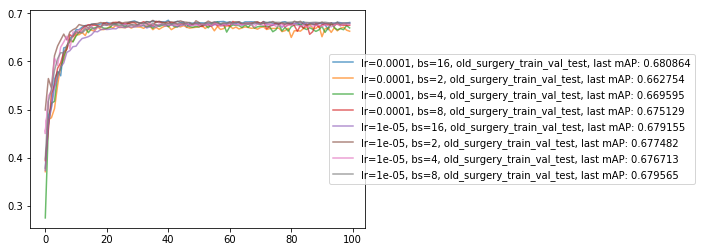

In [53]:
for df in dfs_old:
    if df['dataset'] == 'old_surgery_train_val_test':
        plt.plot(df['df']['epoch'], 
                 df['df']['mAP'],
                 label='lr={}, bs={}, {}, last mAP: {:3f}'.format(df['lr'], df['bs'], df['dataset'], df['df']['mAP'].iloc[-1]),
                 ls=ls, alpha=0.7)
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))

So with our repo, we seem to get competitive numbers around what we previous had (~0.678 vs 0.627) with the previous dataset. Our pipeline seems reasonable.

Next are results comparing evaluation on the new vs old test set. Some are incomplete (jobs still running).

### Train + Val = old dataset, Test = new dataset:

Training on the old data but evaluating on the new test set, we get higher than if we trained on the new dataset (probably explained by the video overlap, around 70% of all videos in the new test set are represented in the train + val sets of the old data), but this is a substantial drop compared to above.

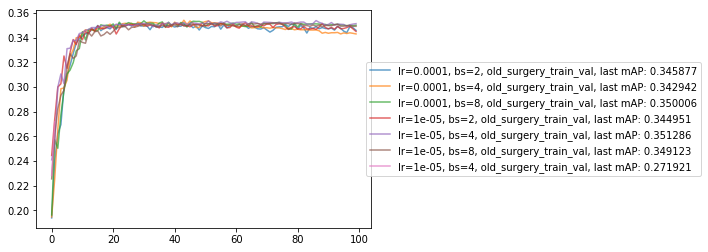

In [52]:
for df in dfs_old:
    if df['dataset'] == 'old_surgery_train_val':
        plt.plot(df['df']['epoch'], 
                 df['df']['mAP'],
                 label='lr={}, bs={}, {}, last mAP: {:3f}'.format(df['lr'], df['bs'], df['dataset'], df['df']['mAP'].iloc[-1]),
                 ls=ls, alpha=0.7)
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))

### Train + Val = new dataset, Test = old dataset:

Still many more epochs to go, but we can already see that training on the current dataset but evaluating on the older dataset, we get mAPs close to what was reported in the paper.

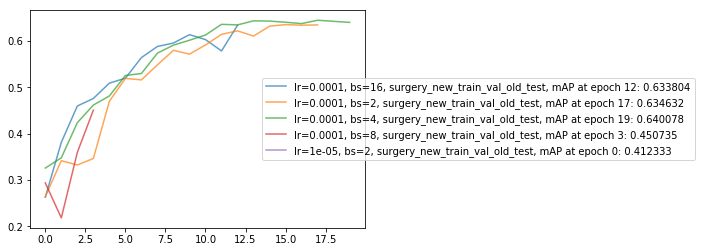

In [51]:
for df in dfs_old:
    if df['dataset'] == 'surgery_new_train_val_old_test':
        plt.plot(df['df']['epoch'], 
                 df['df']['mAP'],
                 label='lr={}, bs={}, {}, mAP at epoch {}: {:3f}'.format(
                     df['lr'], df['bs'], df['dataset'], df['df']['epoch'].iloc[-1],
                     df['df']['mAP'].iloc[-1]),
                 ls=ls, alpha=0.7)
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))